In [21]:
import pandas as pd
import datetime as dt
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from RandomForestForTimeSeriesRegressor import RandomForestForTimeSeriesRegressor, BLOCK_TYPES

In [22]:
dataset = pd.read_csv('yahoo_dataset.csv')

In [23]:
dataset = dataset.dropna()
dataset = dataset.sort_values("Date")
dataset

,Date,Ticker,Open,High,Low,Close,Adj_close,Volume
2285919,1 abr 1970,ED,6.94,6.97,6.88,6.94,0.24,40400
2262652,1 abr 1970,HPQ,0.31,0.32,0.31,0.32,0.11,2578982
808675,1 abr 1970,BA,0.75,0.75,0.74,0.74,0.22,473850
1281914,1 abr 1970,MMM,5.49,5.59,5.49,5.55,1.01,288954
203874,1 abr 1970,CVX,2.78,2.84,2.78,2.84,0.37,1028800
...,...,...,...,...,...,...,...,...
3206090,9 sept 2024,JBHT,167.67,171.95,167.67,171.74,170.90,615800
2235682,9 sept 2024,DD,79.60,80.79,79.46,79.56,78.80,2999700
1768355,9 sept 2024,ODFL,185.98,190.99,185.77,189.78,189.25,1445200
3037329,9 sept 2024,CMS,68.00,69.24,67.85,69.12,68.06,2466300


In [24]:
from dateutil import parser

# Diccionario para traducir meses en español a inglés
MESES_ESP = {
    "ene": "Jan", "feb": "Feb", "mar": "Mar", "abr": "Apr", "may": "May", "jun": "Jun",
    "jul": "Jul", "ago": "Aug", "sep": "Sep", "oct": "Oct", "nov": "Nov", "dic": "Dec"
}

def corregir_fecha(fecha_str):
    try:
        partes = fecha_str.split()
        if len(partes) == 3:  # Asegurar que tiene día, mes y año
            dia, mes, anio = partes
            mes = MESES_ESP.get(mes.lower(), mes)  # Traducir mes al inglés
            fecha_corregida = f"{dia} {mes} {anio}"
            fecha_dt = parser.parse(fecha_corregida, dayfirst=True)  # Convertir a datetime
            return fecha_dt.strftime("%Y-%m-%d")  # Devolver en formato legible
    except Exception as e:
        print(f"Error con la fecha: {fecha_str} - {e}")
        return None  # Retorna None si hay un error

def actualizar_fecha(df, columna):
    df[columna] = df[columna].apply(lambda x: corregir_fecha(x) if pd.notna(x) else None)
    return df

dataset = actualizar_fecha(dataset, "Date")
dataset

,Date,Ticker,Open,High,Low,Close,Adj_close,Volume
2285919,1970-04-01,ED,6.94,6.97,6.88,6.94,0.24,40400
2262652,1970-04-01,HPQ,0.31,0.32,0.31,0.32,0.11,2578982
808675,1970-04-01,BA,0.75,0.75,0.74,0.74,0.22,473850
1281914,1970-04-01,MMM,5.49,5.59,5.49,5.55,1.01,288954
203874,1970-04-01,CVX,2.78,2.84,2.78,2.84,0.37,1028800
...,...,...,...,...,...,...,...,...
3206090,2024-09-09,JBHT,167.67,171.95,167.67,171.74,170.90,615800
2235682,2024-09-09,DD,79.60,80.79,79.46,79.56,78.80,2999700
1768355,2024-09-09,ODFL,185.98,190.99,185.77,189.78,189.25,1445200
3037329,2024-09-09,CMS,68.00,69.24,67.85,69.12,68.06,2466300


In [25]:
def calculateFields(dataset):
    if 'Date' not in dataset:
        dataset['Date'] = dataset['date']
        dataset = dataset.drop(columns=["date"])
    if 'Adj Close' in dataset:
        dataset = dataset.drop(columns=['Adj Close'])
    if 'Adj Close' in dataset:
        dataset = dataset.drop(columns=['Adj_close'])
    dataset['Date'] = pd.to_datetime(dataset['Date'])
    dataset['DateOrdinal'] = dataset['Date'].map(dt.datetime.toordinal)
    dataset['average_price'] = dataset[['Low', 'High']].mean(axis=1)
    dataset = dataset.drop(columns=["Volume", "Close", "Open", "Low", "High"])
    dataset['DayOfWeek'] = dataset['Date'].dt.dayofweek
    dataset['Month'] = dataset['Date'].dt.month
    dataset['Year'] = dataset['Date'].dt.year
    dataset['DayOfYear'] = dataset['Date'].dt.dayofyear
    dataset['WeekOfYear'] = dataset['Date'].dt.isocalendar().week

    dataset['is_start_of_month'] = (dataset['Date'].dt.day == 1).astype(int)
    dataset['is_end_of_month'] = (dataset['Date'] == dataset['Date'] + pd.offsets.MonthEnd(0)).astype(int)
    dataset['quarter'] = dataset['Date'].dt.quarter
    def get_season(month):
        if month in [12, 1, 2]:
            return 0#'winter'
        elif month in [3, 4, 5]:
            return 1#'spring'
        elif month in [6, 7, 8]:
            return 2#'summer'
        else:
            return 3#'autumn'
    dataset['season'] = dataset['Month'].apply(get_season)
    dataset['SerieNumber'] = (dataset['Date'] - dataset['Date'].min()).dt.days + 1


    days_ago = 30

    dataset["price_30_days_ago"] = dataset["average_price"].shift(days_ago)
    dataset["price_180_days_ago"] = dataset["average_price"].shift(180)
    dataset["price_365_days_ago"] = dataset["average_price"].shift(365)


    dataset = dataset.dropna().reset_index(drop=True)
    if 'Symbol' in dataset:
        dataset['Symbol'] = pd.factorize(dataset.Symbol)[0]
    else:
        dataset['Symbol'] = pd.factorize(dataset.Ticker)[0]
        dataset = dataset.drop(columns=['Ticker'])

    return dataset

calculatedFields = ["DateOrdinal", "DayOfWeek", "Month", "Year", "DayOfYear", "WeekOfYear", "is_start_of_month", "is_end_of_month", "quarter",
                    "season", "SerieNumber", "price_30_days_ago", "price_180_days_ago", "price_365_days_ago", "Symbol"]
fieldsPrice = ["average_price"]


dataset = calculateFields(dataset)
dataset

,Date,Adj_close,DateOrdinal,average_price,DayOfWeek,Month,Year,DayOfYear,WeekOfYear,is_start_of_month,is_end_of_month,quarter,season,SerieNumber,price_30_days_ago,price_180_days_ago,price_365_days_ago,Symbol
0,1980-04-01,0.13,722906,0.175,1,4,1980,92,14,1,0,2,1,3743,0.610,2.205,6.925,0
1,1980-04-01,5.77,722906,16.880,1,4,1980,92,14,1,0,2,1,3743,11.960,1.720,0.315,1
2,1980-04-01,1.22,722906,5.180,1,4,1980,92,14,1,0,2,1,3743,7.640,4.875,0.745,2
3,1980-04-01,0.32,722906,1.255,1,4,1980,92,14,1,0,2,1,3743,6.315,2.595,5.540,3
4,1980-04-01,0.55,722906,1.655,1,4,1980,92,14,1,0,2,1,3743,3.435,1.020,2.810,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4051916,2024-09-09,170.90,739138,169.810,0,9,2024,253,37,0,0,3,3,19975,114.500,362.785,141.740,194
4051917,2024-09-09,78.80,739138,80.125,0,9,2024,253,37,0,0,3,3,19975,57.230,11.120,71.645,21
4051918,2024-09-09,189.25,739138,188.380,0,9,2024,253,37,0,0,3,3,19975,54.415,33.745,160.075,248
4051919,2024-09-09,68.06,739138,68.545,0,9,2024,253,37,0,0,3,3,19975,226.185,109.735,228.220,1


In [26]:
dataset['Symbol'] = pd.factorize(dataset.Symbol)[0]

In [27]:
trainPercent = 80
trainSamples = (len(dataset.index) // 100) * trainPercent
testSamples = len(dataset.index) - trainSamples

In [28]:
def getRandomBlock(dataset0, blockDayRange):
    max_date = pd.to_datetime(dataset0['Date'].max())
    min_valid_date = max_date - pd.DateOffset(years=1)  # Fecha máxima menos un año
    
    valid_dates = dataset0[dataset0['Date'] <= min_valid_date]['Date']
    if valid_dates.empty:
        raise ValueError("No hay fechas válidas en el rango permitido.")
    
    random_start_date = np.random.choice(valid_dates)
    end_date = random_start_date + pd.DateOffset(days=blockDayRange)
    
    filtered_df = dataset0[(dataset0['Date'] >= random_start_date) & (dataset0['Date'] <= end_date)]
    return filtered_df

In [29]:
def getRandomTrainTestData(dataset0, daysRange, trainDays):
    blockDf = getRandomBlock(dataset0, daysRange)
    min_date = pd.to_datetime(blockDf['Date'].min())
    train_max_day = min_date + pd.DateOffset(days=trainDays)
    trainSamples = blockDf[blockDf['Date'] < train_max_day].shape[0]
    testSamples = len(blockDf.index) - trainSamples

    aux = blockDf.copy()
    aux = aux.drop("Date", axis=1)
    X = aux[calculatedFields].copy()
    aux = aux.drop(calculatedFields, axis=1)

    Y = aux.copy()

    X_train = X.iloc[:trainSamples]
    Y_train = Y.iloc[:trainSamples]
    X_test = X.iloc[-testSamples:]
    Y_test = Y.iloc[-testSamples:]

    return X_train, Y_train, X_test, Y_test, blockDf

In [30]:
def getTestSet(dataset0, blockDf0, daysRange):
    min_date = pd.to_datetime(blockDf0['Date'].max())
    max_date = min_date + pd.DateOffset(days=daysRange)
    filtered_df = dataset0[(dataset0['Date'] >= min_date) & (dataset0['Date'] <= max_date)]
    aux = filtered_df.copy()
    aux = aux.drop("Date", axis=1)
    X_test = aux[calculatedFields].copy()
    aux = aux.drop(calculatedFields, axis=1)

    Y_test = aux.copy()

    return X_test, Y_test

In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

testRanges = [30, 90, 180, 365, 730, 1825]

def getRmse(dataset01, blockDf01, rfModel, testRangesIdx):
    X_test0, Y_test0 = getTestSet(dataset01, blockDf01, testRanges[testRangesIdx])
    y_pred = rfModel.predict(X_test0)
    rmse01 = sqrt(mean_squared_error(Y_test0, y_pred))
    return rmse01

def testRftsAndGetRmseByAlgorithm(dataset0, daysOfBlocks0, daysOfTraining0, block_size0, algorithm0):
    X_train0, Y_train0, X_test0, Y_test0, blockDf00 = getRandomTrainTestData(dataset0, daysOfBlocks0, daysOfTraining0)
    rfts = RandomForestForTimeSeriesRegressor(n_jobs=5, n_estimators=100, block_size=block_size0, max_depth=10, block_type=BLOCK_TYPES[algorithm0])
    rfts.fit(X_train0, Y_train0)
    rmse0 = dict()
    rmse0[testRanges[0]] = getRmse(dataset0, blockDf00, rfts, 0)
    rmse0[testRanges[1]] = getRmse(dataset0, blockDf00, rfts, 1)
    rmse0[testRanges[2]] = getRmse(dataset0, blockDf00, rfts, 2)
    rmse0[testRanges[3]] = getRmse(dataset0, blockDf00, rfts, 3)
    rmse0[testRanges[4]] = getRmse(dataset0, blockDf00, rfts, 4)
    rmse0[testRanges[5]] = getRmse(dataset0, blockDf00, rfts, 5)
    return rmse0

def testTfAndGetRmse(dataset0, daysOfBlocks0, daysOfTraining0):
    X_train0, Y_train0, X_test0, Y_test0, blockDf00 = getRandomTrainTestData(dataset0, daysOfBlocks0, daysOfTraining0)
    basicRF = RandomForestRegressor(n_jobs=5, n_estimators=100, max_depth=10)
    basicRF.fit(X_train0, Y_train0)
    rmse0 = dict()
    rmse0[testRanges[0]] = getRmse(dataset0, blockDf00, basicRF, 0)
    rmse0[testRanges[1]] = getRmse(dataset0, blockDf00, basicRF, 1)
    rmse0[testRanges[2]] = getRmse(dataset0, blockDf00, basicRF, 2)
    rmse0[testRanges[3]] = getRmse(dataset0, blockDf00, basicRF, 3)
    rmse0[testRanges[4]] = getRmse(dataset0, blockDf00, basicRF, 4)
    rmse0[testRanges[5]] = getRmse(dataset0, blockDf00, basicRF, 5)
    return rmse0

def testTfAndGetRmse2(dataset0, daysOfBlocks0, daysOfTraining0, block_size0):
    X_train0, Y_train0, X_test0, Y_test0, blockDf00 = getRandomTrainTestData(dataset0, daysOfBlocks0, daysOfTraining0)
    basicRF = RandomForestRegressor(n_jobs=5, n_estimators=100, max_depth=10)
    basicRF.fit(X_train0, Y_train0)
    rmse0 = dict()
    rmse0[testRanges[0]] = getRmse(dataset0, blockDf00, basicRF, 0)
    rmse0[testRanges[1]] = getRmse(dataset0, blockDf00, basicRF, 1)
    rmse0[testRanges[2]] = getRmse(dataset0, blockDf00, basicRF, 2)
    rmse0[testRanges[3]] = getRmse(dataset0, blockDf00, basicRF, 3)
    rmse0[testRanges[4]] = getRmse(dataset0, blockDf00, basicRF, 4)
    rmse0[testRanges[5]] = getRmse(dataset0, blockDf00, basicRF, 5)
    rmseList0 = [rmse0]
    for i in [0, 1, 2]:
        rfts = RandomForestForTimeSeriesRegressor(n_jobs=5, n_estimators=100, block_size=block_size0, max_depth=10, block_type=BLOCK_TYPES[i])
        rfts.fit(X_train0, Y_train0)
        rmse1 = dict()
        rmse1[testRanges[0]] = getRmse(dataset0, blockDf00, rfts, 0)
        rmse1[testRanges[1]] = getRmse(dataset0, blockDf00, rfts, 1)
        rmse1[testRanges[2]] = getRmse(dataset0, blockDf00, rfts, 2)
        rmse1[testRanges[3]] = getRmse(dataset0, blockDf00, rfts, 3)
        rmse1[testRanges[4]] = getRmse(dataset0, blockDf00, rfts, 4)
        rmse1[testRanges[5]] = getRmse(dataset0, blockDf00, rfts, 5)
        rmseList0.append(rmse1)
    return rmseList0

def getGraphData(presitionDataArray, bRfp, bs):
    all_arr = [bRfp]
    ticksIdx = [0]
    ticksNames = ["RF"]
    idx = 0
    for blockSize in bs:
        
        data0 = []
        for r in presitionDataArray[blockSize]:
            data0.append(presitionDataArray[blockSize][r])

        all_arr.append(data0)
        idx += 1
        ticksIdx.append(idx)
        ticksNames.append(str(blockSize))

    return all_arr, ticksIdx, ticksNames

def convertListOfDictToDictOfList(dictList0):
    newDict = dict()
    for dict0 in dictList0:
        for key in dict0:
            if key not in newDict:
                newDict[key] = []
            newDict[key].append(dict0[key])
    return newDict

def runTestsAndGetResults(DaysRange, DaysTrainRange, blockSizes):

    daysOfBlocks = DaysRange
    daysOfTraining = DaysTrainRange
    for i in range(len(blockSizes)):
        blockSizes[i] = int(blockSizes[i])

    basicRFPrecision = []
    for i in range(50):
        rmse = testTfAndGetRmse(dataset, DaysRange, DaysTrainRange)
        basicRFPrecision.append(rmse)
    basicRFPrecision = convertListOfDictToDictOfList(basicRFPrecision)
    # Queda una estructura:
    #           Dict, Clave: Tamaño del conjunto de prueba
    #                 Valor: Array con RMSE (50 pruebas)

    precisionNonOverlapping = dict()
    for block_size in blockSizes:
        precisionNonOverlapping[block_size] = []
        for i in range(50):
            rmse0 = testRftsAndGetRmseByAlgorithm(dataset, daysOfBlocks, daysOfTraining, block_size, 0)
            precisionNonOverlapping[block_size].append(rmse0)
    
    precisionMovingBlock = dict()
    for block_size in blockSizes:
        precisionMovingBlock[block_size] = []
        for i in range(50):
            rmse0 = testRftsAndGetRmseByAlgorithm(dataset, daysOfBlocks, daysOfTraining, block_size, 1)
            precisionMovingBlock[block_size].append(rmse0)
    
    precisionCircularBlock = dict()
    for block_size in blockSizes:
        precisionCircularBlock[block_size] = []
        for i in range(50):
            rmse0 = testRftsAndGetRmseByAlgorithm(dataset, daysOfBlocks, daysOfTraining, block_size, 2)
            precisionCircularBlock[block_size].append(rmse0)
    
    for block_size in blockSizes:
        precisionNonOverlapping[block_size] = convertListOfDictToDictOfList(precisionNonOverlapping[block_size])
        precisionMovingBlock[block_size] = convertListOfDictToDictOfList(precisionMovingBlock[block_size])
        precisionCircularBlock[block_size] = convertListOfDictToDictOfList(precisionCircularBlock[block_size])

    return basicRFPrecision, precisionNonOverlapping, precisionMovingBlock, precisionCircularBlock

def showGraph(basicRFPrecision, precisionNonOverlapping, precisionMovingBlock, precisionCircularBlock, blockSizes):
    all_arr, ticksIdx, ticksNames = getGraphData(precisionNonOverlapping, basicRFPrecision, blockSizes)
    all_arr1, ticksIdx, ticksNames = getGraphData(precisionMovingBlock, basicRFPrecision, blockSizes)
    all_arr2, ticksIdx, ticksNames = getGraphData(precisionCircularBlock, basicRFPrecision, blockSizes)

    def set_box_color(bp, color):
        plt.setp(bp['boxes'], color=color)
        plt.setp(bp['whiskers'], color=color)
        plt.setp(bp['caps'], color=color)
        plt.setp(bp['medians'], color=color)

    plt.figure()

    bp0 = plt.boxplot(all_arr, positions=np.array(range(len(all_arr)))*2.0-0.5, sym='', widths=0.3)
    bp1 = plt.boxplot(all_arr1, positions=np.array(range(len(all_arr1)))*2.0, sym='', widths=0.3)
    bp2 = plt.boxplot(all_arr2, positions=np.array(range(len(all_arr1)))*2.0+0.5, sym='', widths=0.3)
    set_box_color(bp0, '#D7191C') # colors are from http://colorbrewer2.org/
    set_box_color(bp1, '#2C7BB6')
    set_box_color(bp2, '#fdc086')

    # draw temporary red and blue lines and use them to create a legend
    plt.plot([], c='#D7191C', label='Non Overlapping')
    plt.plot([], c='#2C7BB6', label='Moving Block')
    plt.plot([], c='#fdc086', label='Circular Block')
    plt.legend()

    plt.xticks(range(0, len(ticksNames) * 2, 2), ticksNames)
    plt.tight_layout()
    plt.title(f"Comparación entre alternativas de bootstraps (Train: {DaysTrainRange} días | Test: {DaysRange - DaysTrainRange} días)")
    plt.xlabel("Tamaño de bloque")
    plt.ylabel("RMSE")

In [32]:
def runTestsAndGetResults2(DaysRange, DaysTrainRange, blockSizes):

    basicRFPrecision = []
    precisionNonOverlapping = dict()
    precisionMovingBlock = dict()
    precisionCircularBlock = dict()
    block_size = blockSizes[0]
    precisionNonOverlapping[block_size] = []
    precisionMovingBlock[block_size] = []
    precisionCircularBlock[block_size] = []
    for i in range(50):
        rmseList = testTfAndGetRmse2(dataset, DaysRange, DaysTrainRange, block_size)
        basicRFPrecision.append(rmseList[0])
        precisionNonOverlapping[block_size].append(rmseList[1])
        precisionMovingBlock[block_size].append(rmseList[2])
        precisionCircularBlock[block_size].append(rmseList[3])
    
    basicRFPrecision = convertListOfDictToDictOfList(basicRFPrecision)
    # Queda una estructura:
    #           Dict, Clave: Tamaño del conjunto de prueba
    #                 Valor: Array con RMSE (50 pruebas)
        
    for block_size0 in blockSizes:
        precisionNonOverlapping[block_size0] = convertListOfDictToDictOfList(precisionNonOverlapping[block_size0])
        precisionMovingBlock[block_size0] = convertListOfDictToDictOfList(precisionMovingBlock[block_size0])
        precisionCircularBlock[block_size0] = convertListOfDictToDictOfList(precisionCircularBlock[block_size0])

    return basicRFPrecision, precisionNonOverlapping, precisionMovingBlock, precisionCircularBlock

In [33]:
def runTestAndCompareOneSigleBlockSize(TrainDays, bSize):
    bs = [bSize]
    FrRMSE, NoRMSE, BmRMSE, CbRMSE = runTestsAndGetResults(TrainDays + max(testRanges), TrainDays, bs)
    showGraph(FrRMSE, NoRMSE[bSize], BmRMSE[bSize], CbRMSE[bSize], bs)
    

In [34]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

def getLinesGraphData(rfReference):
    ticks0 = []
    rfReferenceMeans = []
    for key in rfReference:
        ticks0.append(str(key))
        rfReferenceMeans.append(sum(rfReference[key]) / len(rfReference[key]))
    rfReferenceMeans
    return rfReferenceMeans, ticks0

def showGraphLinesForOneBlockSize(basicRFPrecision, precisionNonOverlapping, precisionMovingBlock, precisionCircularBlock, descr):
    all_arr0, ticksNames = getLinesGraphData(basicRFPrecision)
    all_arr, ticksNames = getLinesGraphData(precisionNonOverlapping)
    all_arr1, ticksNames = getLinesGraphData(precisionMovingBlock)
    all_arr2, ticksNames = getLinesGraphData(precisionCircularBlock)

    plt.figure()

    bp3 = plt.plot(all_arr0, color='red', label="Random Forest") #, positions=np.array(range(len(all_arr0)))*2.0-0.5, sym='', widths=0.3)
    bp0 = plt.plot(all_arr, color='blue', label="RFTS Non Overlaping")  #, positions=np.array(range(len(all_arr)))*2.0-0.5, sym='', widths=0.3)
    bp1 = plt.plot(all_arr1, color='cyan', label="RFTS Moving Block") #, positions=np.array(range(len(all_arr1)))*2.0, sym='', widths=0.3)
    bp2 = plt.plot(all_arr2, color='yellow', label="RFTS Circular Block") #, positions=np.array(range(len(all_arr2)))*2.0+0.5, sym='', widths=0.3)
    #bp3.colo
    # set_box_color(bp3, '#f03b20')
    # set_box_color(bp0, '#D7191C') # colors are from http://colorbrewer2.org/
    # set_box_color(bp1, '#2C7BB6')
    # set_box_color(bp2, '#fdc086')

    plt.legend()

    plt.xticks(range(0, len(ticksNames)), ticksNames)
    plt.tight_layout()
    plt.title(f"Comparación entre algoritmos ({descr})")
    plt.xlabel("Dias del conjunto de pruebas")
    plt.ylabel("RMSE")

In [35]:
def runTrainTimeTest(trainDays, blockSize):
    bs = [blockSize]
    FrRMSE, NoRMSE, BmRMSE, CbRMSE = runTestsAndGetResults(trainDays + max(testRanges), trainDays, bs)
    graphDescr = f"Train: {trainDays} días, 50 pruebas, bloques {blockSize} muestras"
    showGraphLinesForOneBlockSize(FrRMSE, NoRMSE[blockSize], BmRMSE[blockSize], CbRMSE[blockSize],graphDescr )

In [36]:
def runTestAndCompareOneSigleBlockSize2(TrainDays, bSize):
    bs = [bSize]
    FrRMSE, NoRMSE, BmRMSE, CbRMSE = runTestsAndGetResults2(TrainDays + max(testRanges), TrainDays, bs)
    graphDescr = f"Train: {TrainDays} días, 50 pruebas, bloques {bSize} muestras"
    showGraphLinesForOneBlockSize(FrRMSE, NoRMSE[bSize], BmRMSE[bSize], CbRMSE[bSize],graphDescr)

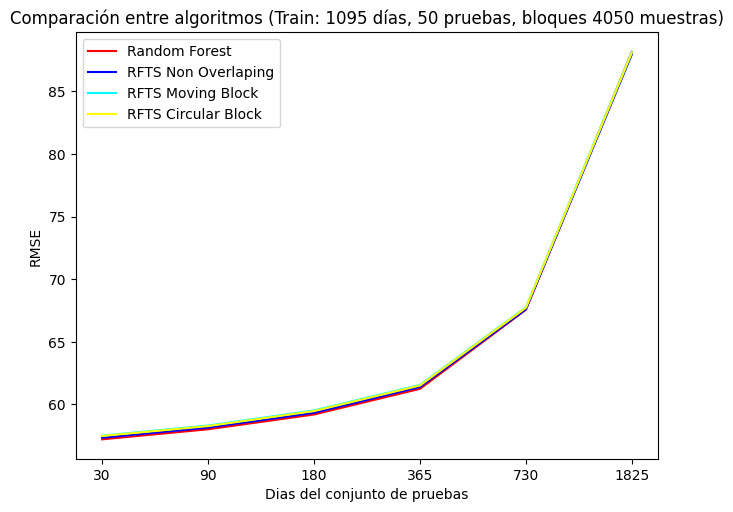

In [37]:
runTestAndCompareOneSigleBlockSize2(int(365 * 3), int(1350 * 3))

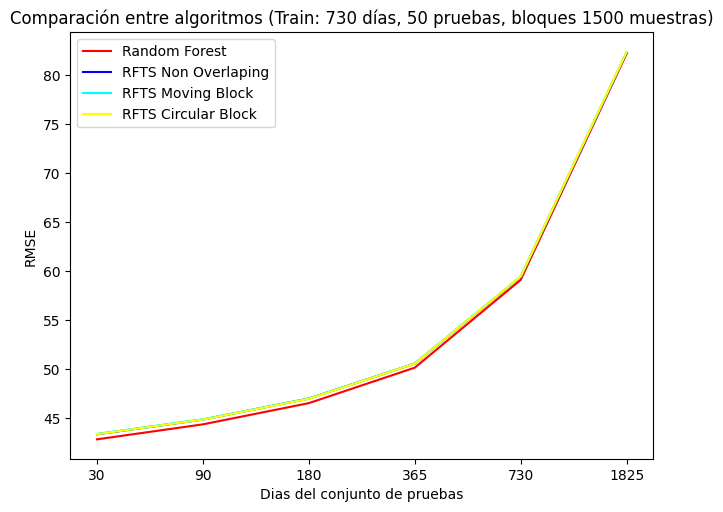

In [38]:
runTestAndCompareOneSigleBlockSize2(365 * 2, 1500)

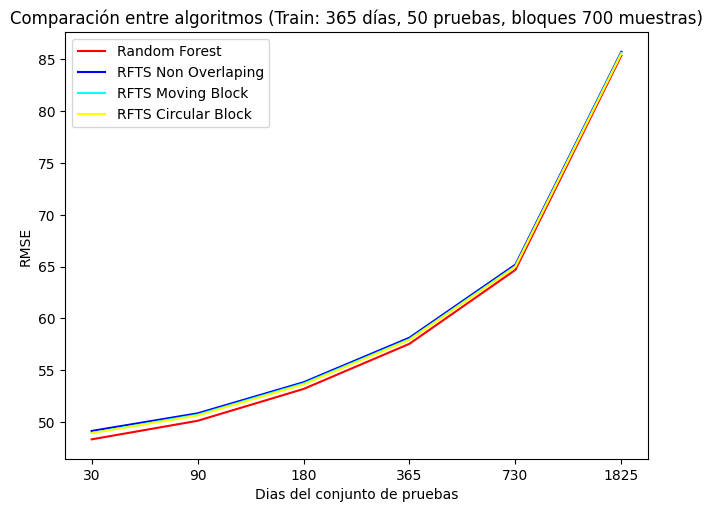

In [39]:
runTestAndCompareOneSigleBlockSize2(365, 700)

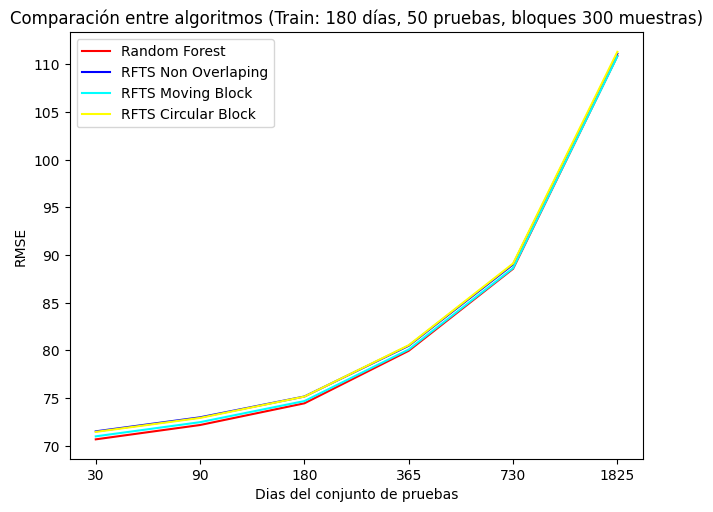

In [40]:
runTestAndCompareOneSigleBlockSize2(180, 300)

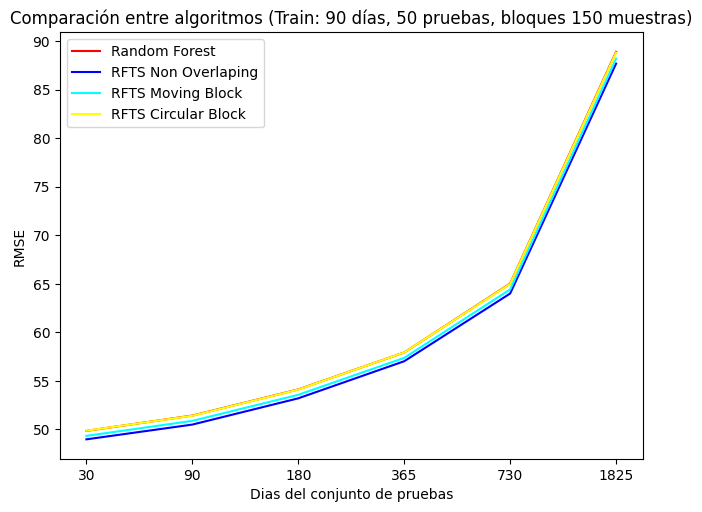

In [41]:
runTestAndCompareOneSigleBlockSize2(90, 150)

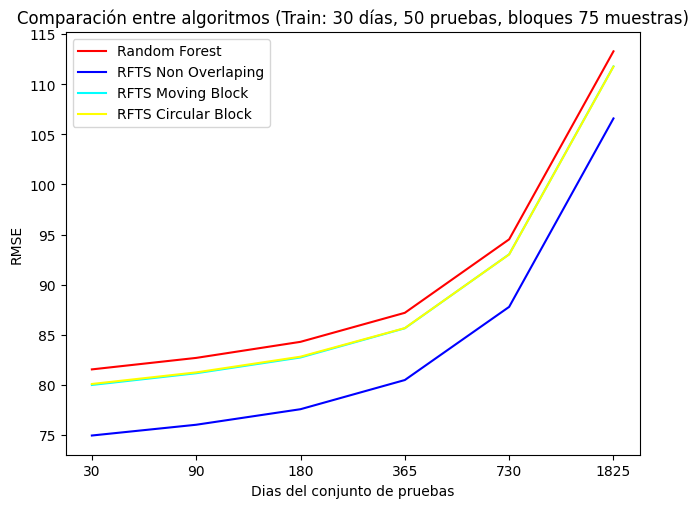

In [42]:
runTestAndCompareOneSigleBlockSize2(30, 75)

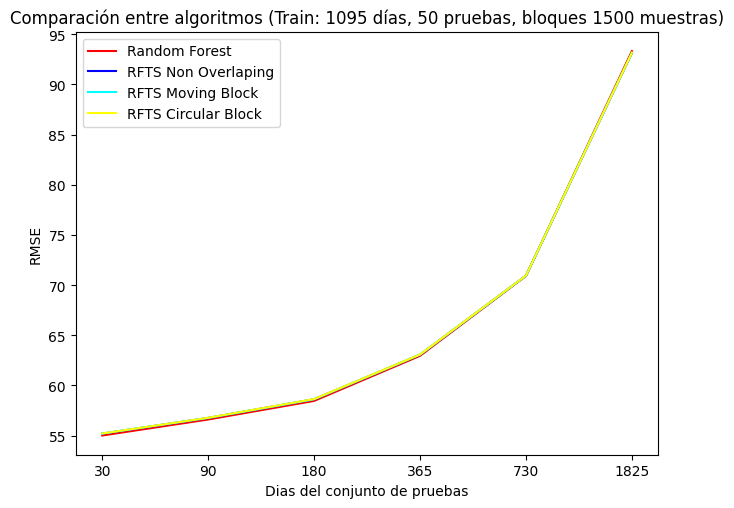

In [43]:
runTestAndCompareOneSigleBlockSize2(int(365 * 3), 1500)

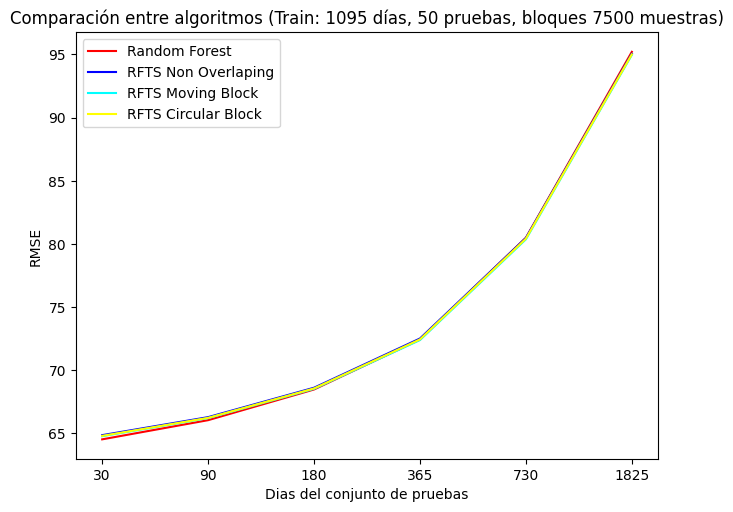

In [44]:
runTestAndCompareOneSigleBlockSize2(int(365 * 3), (1500 * 5))